In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Loading, cleaning, preparing

In [2]:
google_data_last = pd.read_csv('../../data/google_data_last.csv', encoding='ISO-8859-1')

In [3]:
# select only the dating category
dating_category = google_data_last[google_data_last['categ_app'] == 'Dating']

In [4]:
#drop apps which have either no rating or no permissions
dating_category = dating_category.dropna(subset=['permissions', 'nb_rating'])

In [5]:
#dating_category
# filter nb_rating to only include apps with more than 80 ratings, first cast to int and remove commas
dating_category['nb_rating'] = dating_category['nb_rating'].astype(str).str.replace(',', '').astype(int)
dating_category = dating_category[dating_category['nb_rating'] > 112]

In [6]:
# extract all PEGI ratings from the content_rating_app column
dating_category['PEGI_rating'] = dating_category['content_rating_app'].str.extract('PEGI\s(\d+)')
# fill NaN with '0'
dating_category['PEGI_rating'].fillna('0', inplace=True)
# Convert to int
dating_category['PEGI_rating'] = dating_category['PEGI_rating'].astype(int)

In [7]:
def process_permissions(permission_string):
    """
    This function processes the permission string of an app and returns a list of permissions.  
    :param: permission_string: a string of permissions separated by commas
    :return: a list of permissions
    """
    list_items = permission_string.split(',')
    processed_list = [item.strip() for item in list_items]
    processed_list = [item.replace('.', '').lower() for item in processed_list]
    
    # fixing the format of a specific string
    for i in range(len(processed_list)):
        if processed_list[i] == "add or modify calendar events and send email to guests without owners\\ knowledge":
            processed_list[i] = processed_list[i].replace('\\', '')

    return processed_list

dating_category['processed_permissions'] = dating_category['permissions'].apply(process_permissions)


In [8]:
# change booleans to ints
dating_category['in_app'] = dating_category['in_app'].astype(int)
dating_category['has_ads'] = dating_category['has_ads'].astype(int)

In [9]:
dating_category = dating_category.drop(columns=['Unnamed: 0'])
dating_category_clean = dating_category.copy()

In [10]:
# Function to convert strings to integers
def convert_to_int(download_str):
    # Remove non-numeric characters
    clean_str = ''.join(filter(str.isdigit, download_str))
    # Convert to integer
    return int(clean_str)

dating_category['num_downloads_numeric'] = dating_category['num_downloads'].apply(convert_to_int)
dating_category['log_num_downloads'] = np.log(dating_category['num_downloads_numeric'])
dating_category['log_num_ratings'] = np.log(dating_category['nb_rating'])

## Grouping permissions
We have grouped the permissions manually since the google play store does not provide a grouping of permissions. We have used the following websites as a reference: 
- https://developer.android.com/reference/android/Manifest.permission_group
- https://gist.github.com/Watsonboy1989/fa01a6869d82062c770e137107693744#permissionandroidpermissionwrite_external_storage
- https://android.izzysoft.de/applists/perms?lang=en#:~:text=Starting%20with%20Android%2010%2C%20an,use%20it%20to%20download%20files

In [11]:
group_accessibility_non_data = [
    'bind to an accessibility service',
]

group_accounts_non_data = [
    'act as the accountmanagerservice',
    'find accounts on the device',
    'read Google service configuration',
    'use accounts on the device',
    'create accounts and set passwords',
    'add or remove accounts',
    'modify google service configuration',
]

group_app_info_non_data = [
    'run at startup',
]

group_app_info_data = [
    'retrieve running apps',
]

group_bluetooth_non_data = [
    'pair with bluetooth devices',
    'access bluetooth settings'
]

group_camera_non_data = [
    'take pictures and videos'
]

group_development_tools_non_data = [
    'enable app debugging',
    'change system display settings'
]

group_development_tools_data = [
    'read sensitive log data',
]

group_device_alarms_non_data = [
    'set an alarm',
]

group_display_non_data = [
    'draw over other apps',
]

group_battery_life_non_data = [
    'prevent device from sleeping',
    'control vibration',
    'control flashlight',
    'allow wi-fi multicast reception',
]

group_hardware_controls_non_data = [
    'change your audio settings',
    'capture video output', # had no group, but this permission would fit into the HARDWARE_CONTROLS category as it involves access to device hardware (video output).
    'capture audio output', # Similar to the video output permission, this would also belong to the HARDWARE_CONTROLS category, as it is related to capturing audio output from the device hardware.
    'capture secure video output', #This one is a bit more specific but would still fall under HARDWARE_CONTROLS due to its relation to the hardware capturing capabilities, with an additional layer of security.
]

group_location_non_data = [
    'mock location sources for testing',
    'approximate location (network-based)',
    'access extra location provider commands',
]

group_location_data = [
    'precise location (gps and network-based)',
]

group_messages_non_data = [
    'send sms messages',
]

group_messages_data = [
    'read your text messages (sms or mms)',
    'receive text messages (sms)',
]

group_microphone_non_data = [
    'record audio',
]

group_network_non_data = [
    'receive data from internet',
    'full network access',
    'view network connections',
    'receive data from Internet',
    'view wi-fi connections',
    'connect and disconnect from wi-fi',
    'change network connectivity',
    'google play license check',
    'download files without notification',
    'broadcast data messages to apps.',
    'control near field communication',
]

group_network_data = [
    'access download manager',
]

group_personal_info_data = [
    'read your web bookmarks and history',
    'read your contacts',
    'modify your contacts',
    'read your own contact card',
    'read calendar events plus confidential information',
    'add or modify calendar events and send email to guests without owners knowledge',
]

group_phone_calls_non_data = [
    'reroute outgoing calls',
    'read phone status and identity',
    'directly call phone numbers',
    'make/receive sip calls',
    'modify phone state',
]

group_screen_lock_non_data = [
    'disable your screen lock',
]

group_status_bar_non_data = [
    'expand/collapse status bar',
]

group_storage_non_data = [
    'modify or delete the contents of your usb storage',
    'read the contents of your usb storage',
    'manage document storage',
]

group_sync_settings_non_data = [
    'toggle sync on and off',
    'read sync statistics',
    'read sync settings'
]

group_system_tools_non_data = [
    'install shortcuts', # had no group, but this permission would likely belong to the SYSTEM_TOOLS group because it relates to modifying the system's user interface, particularly the home screen layout.
    'uninstall shortcuts', #This permission would go under the SYSTEM_TOOLS group as well, considering it's related to the management of system UI elements like shortcuts.
    'control media playback and metadata access', #The MEDIA_CONTENT_CONTROL permission does allow an application to interact with system-level media controls, such as knowing what content is playing and controlling its playback, which could be considered a system tool feature.
    'modify system settings',
    'power device on or off',
    'close other apps',
    'access usb storage filesystem',
    'send sticky broadcast',
    'read home settings and shortcuts',
    'full license to interact across users',
    'delete all app cache data',
    'reorder running apps',
    'measure app storage space',
    'write home settings and shortcuts',
    'interact across users',
    'send download notifications.',
    'bind to a wallpaper',
    'update component usage statistics'
    'read battery statistics'
    'modify app ops statistics',
]

group_wallpaper_non_data = [
    'adjust your wallpaper size',
    'set wallpaper',
]

group_user_dictionary_non_data = [
    'add words to user-defined dictionary',
    'read terms you added to the dictionary',
]


In [12]:
# Dictionary mapping column names to permission groups
permission_groups = {
    'accessibility_count': group_accessibility_non_data,
    'accounts_count': group_accounts_non_data,
    'app_info_count': group_app_info_non_data,
    'app_info_data_count': group_app_info_data,
    'bluetooth_count': group_bluetooth_non_data,
    'camera_count': group_camera_non_data,
    'development_tools_count': group_development_tools_non_data,
    'development_tools_data_count': group_development_tools_data,
    'device_alarms_count': group_device_alarms_non_data,
    'display_count': group_display_non_data,
    'battery_life_count': group_battery_life_non_data,
    'hardware_controls_count': group_hardware_controls_non_data,
    'location_count': group_location_non_data,
    'location_data_count': group_location_data,
    'messages_count': group_messages_non_data,
    'messages_data_count': group_messages_data,
    'microphone_count': group_microphone_non_data,
    'network_count': group_network_non_data,
    'network_data_count': group_network_data,
    'personal_info_count': group_personal_info_data,
    'phone_calls_count': group_phone_calls_non_data,
    'screen_lock_count': group_screen_lock_non_data,
    'status_bar_count': group_status_bar_non_data,
    'storage_count': group_storage_non_data,
    'sync_settings_count': group_sync_settings_non_data,
    'system_tools_count': group_system_tools_non_data,
    'wallpaper_count': group_wallpaper_non_data,
    'user_dictionary_count': group_user_dictionary_non_data
}

# Function to count permissions
def count_permissions(app_permissions, group):
    return sum(permission in app_permissions for permission in group)

# Loop to create new columns for each permission group
for column_name, group in permission_groups.items():
    dating_category[column_name] = dating_category['processed_permissions'].apply(lambda x: count_permissions(x, group))

In [13]:
# Broader permission groups
broader_permission_groups = {
    'device_system_access_count': group_accessibility_non_data + 
                                  group_bluetooth_non_data + 
                                  group_device_alarms_non_data + 
                                  group_hardware_controls_non_data + 
                                  group_system_tools_non_data +
                                  group_phone_calls_non_data,
    'personal_data_count': group_accounts_non_data + 
                           group_personal_info_data + 
                           group_messages_non_data + 
                           group_user_dictionary_non_data +
                           group_app_info_data +
                           group_development_tools_data +
                           group_location_data +
                           group_network_data,
    'network_connectivity_count': group_network_non_data + 
                                  group_sync_settings_non_data,
    'user_interface_interaction_count': group_app_info_non_data + 
                                        group_camera_non_data + 
                                        group_microphone_non_data + 
                                        group_screen_lock_non_data + 
                                        group_status_bar_non_data + 
                                        group_wallpaper_non_data + 
                                        group_storage_non_data + 
                                        group_display_non_data + 
                                        group_development_tools_non_data + 
                                        group_location_non_data + 
                                        group_battery_life_non_data + 
                                        group_messages_non_data
}

# Function to count permissions
def count_permissions(app_permissions, group):
    return sum(permission in app_permissions for permission in group)

# Loop to create new columns for each broader permission group
for column_name, group in broader_permission_groups.items():
    dating_category[column_name] = dating_category['processed_permissions'].apply(lambda x: count_permissions(x, group))

### Multivariate Analysis

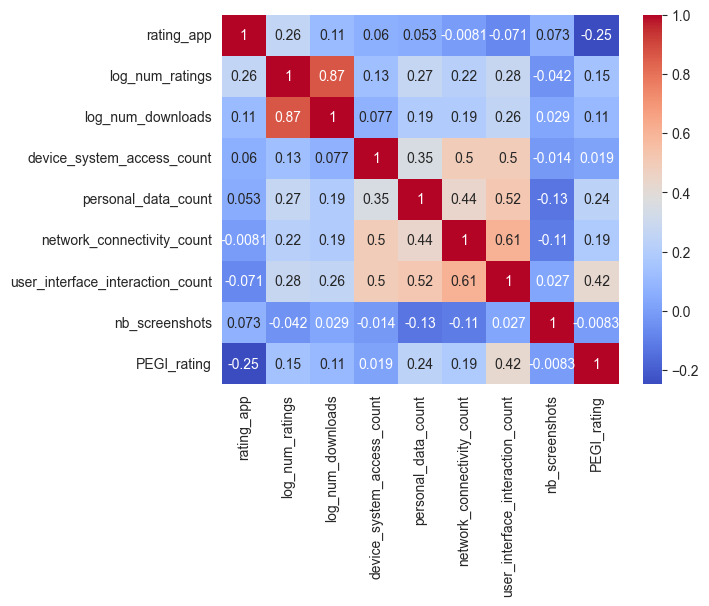

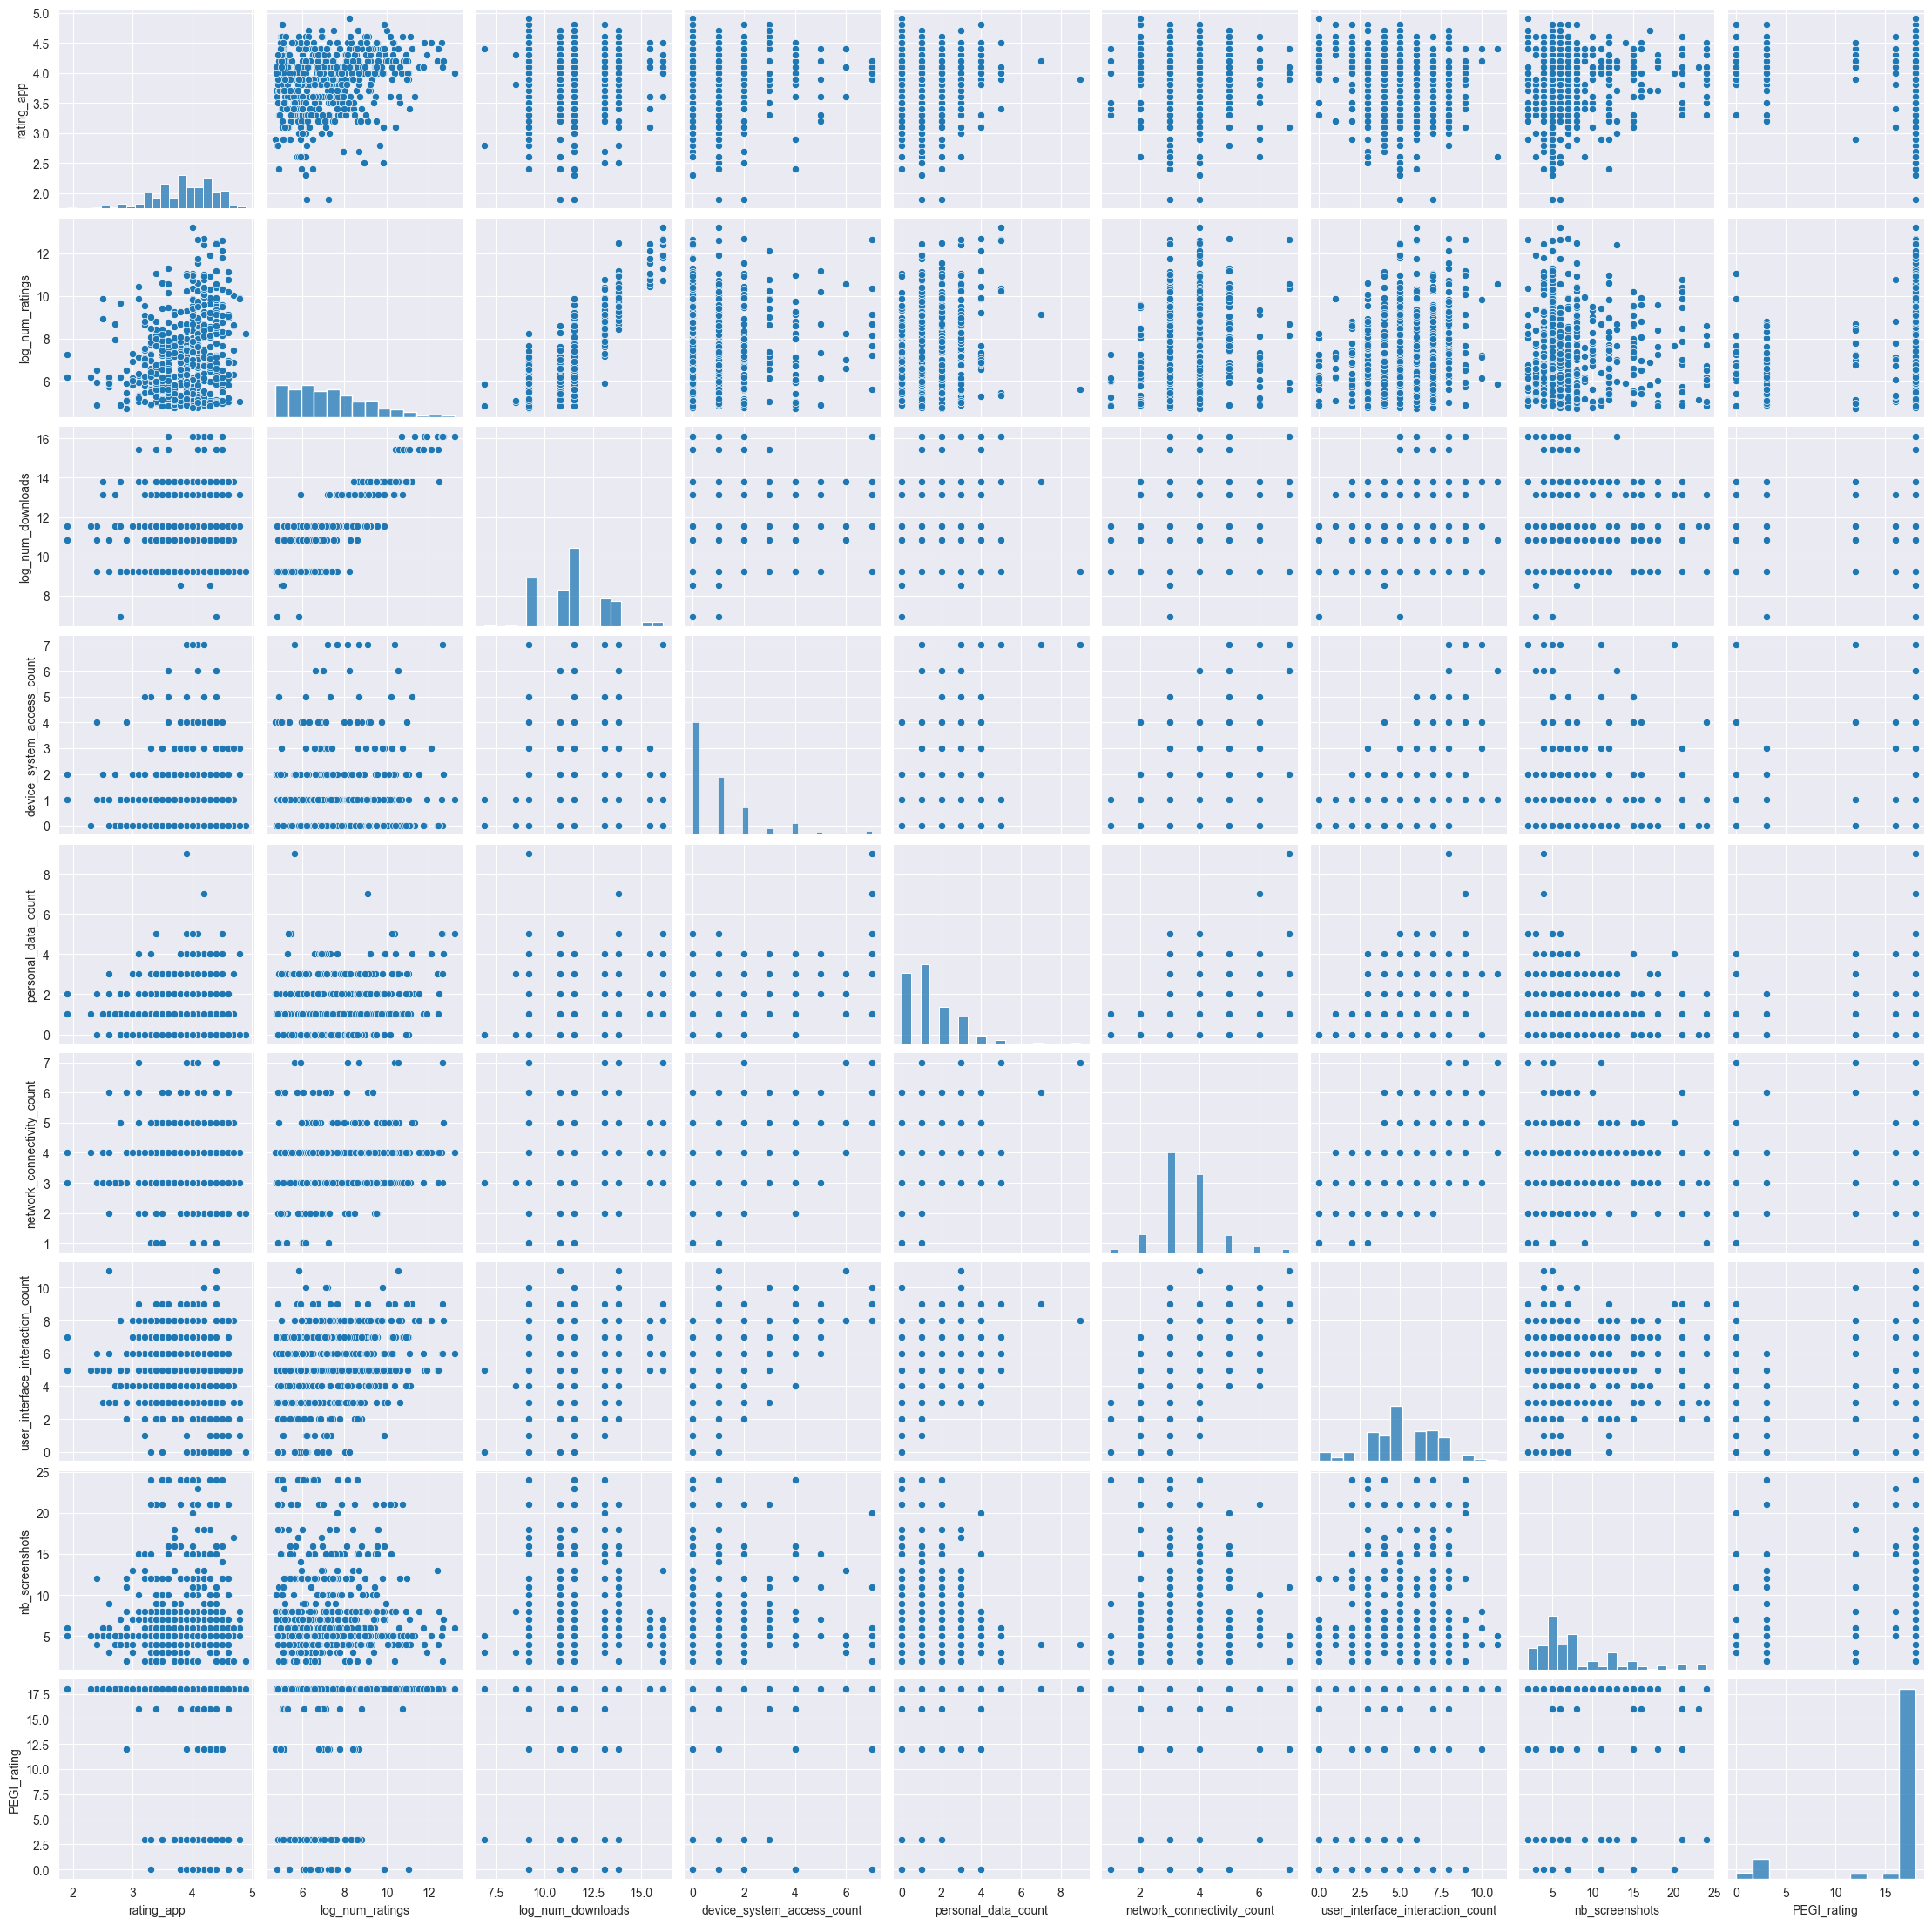

In [14]:
# make correlation matrix for dating category on only the numeric variables (so no dummies)
dating_category_numeric = dating_category[[
    'rating_app',
    'log_num_ratings',
    'log_num_downloads',
    'device_system_access_count',
    'personal_data_count',
    'network_connectivity_count',
    'user_interface_interaction_count',
    'nb_screenshots',
    'PEGI_rating'
]]
corr = dating_category_numeric.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap='coolwarm',
        annot=True,)
plt.show()

sns.pairplot(dating_category_numeric)
plt.show()

# OLS Regression

In [15]:
X = dating_category[[
    'log_num_downloads',
    'log_num_ratings',
    'device_system_access_count',
    'personal_data_count',
    'network_connectivity_count',
    'user_interface_interaction_count',
    'in_app', 'has_ads', 
    'nb_screenshots',
    'PEGI_rating'
]]

X = pd.get_dummies(X, columns=['PEGI_rating'], dtype=int)
X = X.drop(columns=['PEGI_rating_18'])

y = dating_category['rating_app']

# Adding a constant to the model (OLS doesn't include it by default)
X = sm.add_constant(X)

In [16]:
# Creating nested models

# Model 1: Basic model with minimal variables
X1 = dating_category[['personal_data_count']]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y, X1).fit()


# Model 2: Adding more variables
X2 = dating_category[['personal_data_count', 'network_connectivity_count', 'device_system_access_count', 'user_interface_interaction_count']]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit()

# Model 3: Adding all variables except PEGI_rating dummies
X3 = dating_category[['personal_data_count', 'network_connectivity_count', 
                      'device_system_access_count', 'user_interface_interaction_count',
                      'log_num_downloads', 'log_num_ratings']]
X3 = sm.add_constant(X3)
model3 = sm.OLS(y, X3).fit()

# Model 3: Adding all variables except PEGI_rating dummies
X4 = dating_category[['personal_data_count', 'network_connectivity_count', 
                      'device_system_access_count', 'user_interface_interaction_count',
                      'log_num_downloads', 'log_num_ratings',
                      'in_app', 'has_ads', 'nb_screenshots']]
X4 = sm.add_constant(X4)
model4 = sm.OLS(y, X4).fit()

# Model 4: Full model with all variables including PEGI_rating dummies
X5 = pd.get_dummies(dating_category[['personal_data_count', 'network_connectivity_count', 
                                     'device_system_access_count', 'user_interface_interaction_count',
                                     'log_num_downloads', 'log_num_ratings',
                                     'in_app', 'has_ads', 'nb_screenshots', 
                                     'PEGI_rating']], columns=['PEGI_rating'], dtype=int)
X5 = X5.drop(columns=['PEGI_rating_18'])
X5 = sm.add_constant(X5)
model5 = sm.OLS(y, X5).fit()

# Summarizing the models
summary_model1 = model1.summary()
summary_model2 = model2.summary()
summary_model3 = model3.summary()
summary_model4 = model4.summary()
summary_model5 = model5.summary()

## Presenting results

In [17]:
# Combining the model summaries into one table
summary_table = summary_col([model1, model2, model3, model4, model5], 
                                    stars=True, 
                                    model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'],
                                    info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                               'Adj. R-squared': lambda x: f"{x.rsquared_adj:.2f}",
                                               'AIC': lambda x: f"{x.aic:.0f}",
                                               'BIC': lambda x: f"{x.bic:.0f}"},
                                    float_format="%0.3f")

# Generating the combined summary table in LaTeX format
summary_table_latex = summary_table.as_latex()
print(summary_table_latex)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllll}
\hline
                                    & Model 1  & Model 2   & Model 3   & Model 4   & Model 5    \\
\hline
const                               & 3.842*** & 3.993***  & 4.190***  & 4.125***  & 3.982***   \\
                                    & (0.031)  & (0.088)   & (0.168)   & (0.164)   & (0.161)    \\
personal\_data\_count               & 0.021    & 0.043**   & 0.012     & 0.011     & 0.015      \\
                                    & (0.017)  & (0.021)   & (0.020)   & (0.019)   & (0.019)    \\
network\_connectivity\_count        &          & 0.000     & -0.003    & 0.006     & -0.002     \\
                                    &          & (0.030)   & (0.028)   & (0.027)   & (0.026)    \\
device\_system\_access\_count       &          & 0.038**   & 0.035**   & 0.024     & 0.006      \\
                                    &          & (0.018)   & (0.017)   & (0.016)   & (0.016)    \\
user\_interface\_inter

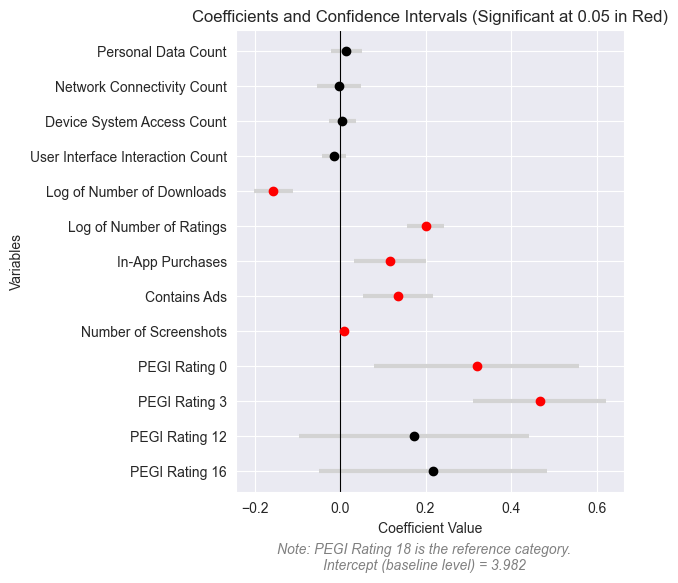

In [18]:
# Custom function with options to reorder variables and change display names
def plot_model_summary_custom(model, variable_order=None, name_mapping=None, significance_level=0.05, figsize=(5, 6)):
    """
    Plots the coefficients and confidence intervals of a regression model.
    Allows reordering of variables and changing of display names.
    Highlights significant predictors at the specified significance level.
    """
    # Extracting coefficients, confidence intervals, p-values, and variable names
    coefficients = model.params.drop('const')
    confidence_intervals = model.conf_int().loc[coefficients.index]
    p_values = model.pvalues.drop('const')

    # Reordering variables if specified
    if variable_order:
        coefficients = coefficients.loc[variable_order]
        confidence_intervals = confidence_intervals.loc[variable_order]
        p_values = p_values.loc[variable_order]

    # Changing variable display names if specified
    variables = coefficients.index
    if name_mapping:
        variables = [name_mapping.get(var, var) for var in variables]

    # Plot
    plt.figure(figsize=figsize)
    for i, var in enumerate(variables):
        original_var = coefficients.index[i]
        color = 'red' if p_values[original_var] < significance_level else 'black'
        plt.errorbar(x=coefficients[original_var], y=i, 
                     xerr=[[coefficients[original_var] - confidence_intervals.loc[original_var][0]], 
                           [confidence_intervals.loc[original_var][1] - coefficients[original_var]]], 
                     fmt='o', color=color, ecolor='lightgray', elinewidth=3, capsize=0)
    plt.axvline(x=0, color='black', linewidth=0.8)
    plt.yticks(ticks=np.arange(len(variables)), labels=variables)
    plt.title('Coefficients and Confidence Intervals (Significant at 0.05 in Red)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Variables')
    plt.figtext(0.5, -0.02, "Note: PEGI Rating 18 is the reference category.\nIntercept (baseline level) = 3.982", ha="center", fontsize=10, color="gray", fontstyle='italic')
    plt.grid(True)
    plt.show()

variable_order = [
    "PEGI_rating_16",
    "PEGI_rating_12",
    "PEGI_rating_3",
    "PEGI_rating_0",
    "nb_screenshots",
    "has_ads",
    "in_app",
    "log_num_ratings",
    "log_num_downloads",
    "user_interface_interaction_count",
    "device_system_access_count",
    "network_connectivity_count",
    "personal_data_count"
]

name_mapping = {
    "personal_data_count": "Personal Data Count",
    "network_connectivity_count": "Network Connectivity Count",
    "device_system_access_count": "Device System Access Count",
    "user_interface_interaction_count": "User Interface Interaction Count",
    "log_num_downloads": "Log of Number of Downloads",
    "log_num_ratings": "Log of Number of Ratings",
    "in_app": "In-App Purchases",
    "has_ads": "Contains Ads",
    "nb_screenshots": "Number of Screenshots",
    "PEGI_rating_0": "PEGI Rating 0",
    "PEGI_rating_3": "PEGI Rating 3",
    "PEGI_rating_12": "PEGI Rating 12",
    "PEGI_rating_16": "PEGI Rating 16"
}

# Plotting with the custom settings
plot_model_summary_custom(model5, variable_order=variable_order, name_mapping=name_mapping)

In [19]:
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     14.08
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           5.93e-27
Time:                        23:36:05   Log-Likelihood:                -293.35
No. Observations:                 515   AIC:                             614.7
Df Residuals:                     501   BIC:                             674.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

## Validating the OLS assumptions

In [20]:
model = model5
X = X5

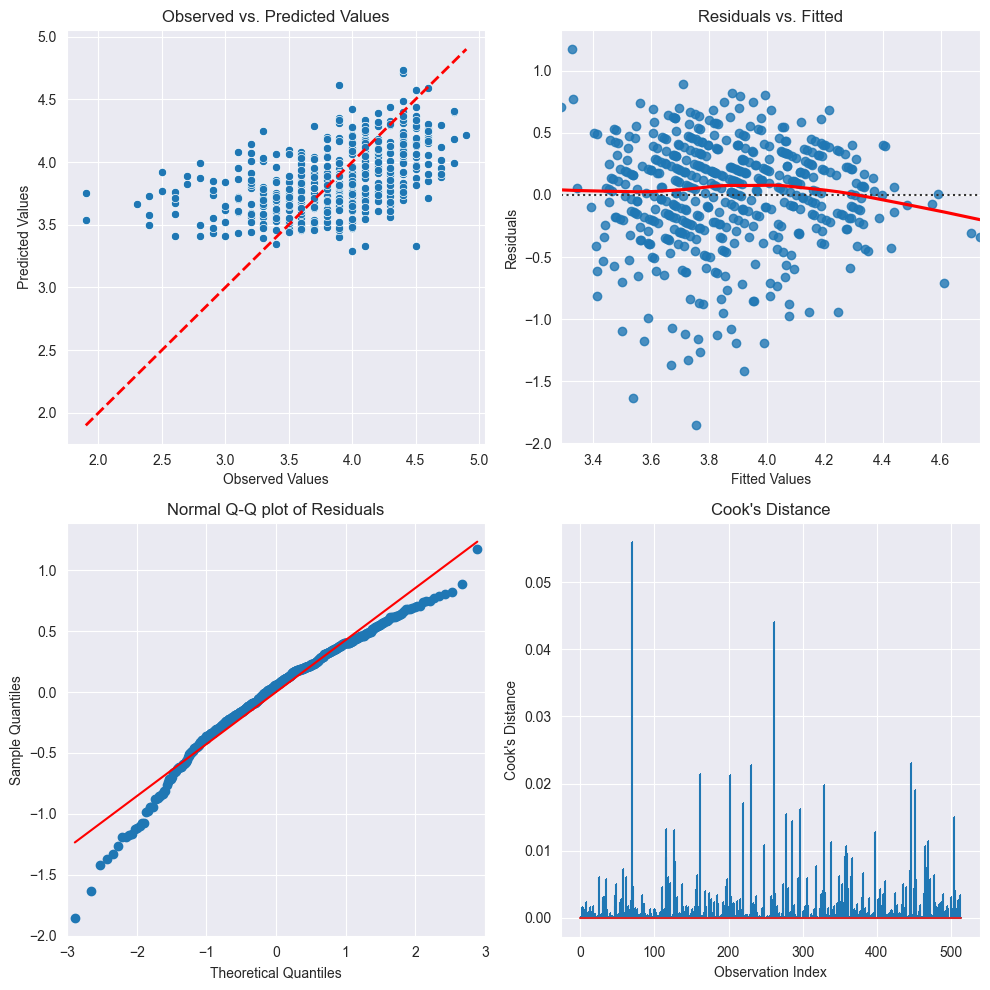

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Assumption 1: Linearity - Observed vs Predicted Values
sns.scatterplot(x=y, y=model.predict(X), ax=axs[0, 0])
axs[0, 0].plot([min(y), max(y)], [min(y), max(y)], color='red', lw=2, linestyle='--')
axs[0, 0].set_xlabel("Observed Values")
axs[0, 0].set_ylabel("Predicted Values")
axs[0, 0].set_title("Observed vs. Predicted Values")

# Assumption 3: Homoscedasticity - Residuals vs Fitted values
sns.residplot(x=model.predict(X), y=model.resid, lowess=True, line_kws={'color': 'red'}, ax=axs[0, 1])
axs[0, 1].set_xlabel("Fitted Values")
axs[0, 1].set_ylabel("Residuals")
axs[0, 1].set_title("Residuals vs. Fitted")

# Assumption 4: Normal Distribution of Errors - Q-Q plot
sm.qqplot(model.resid, line='s', ax=axs[1, 0])
axs[1, 0].set_title("Normal Q-Q plot of Residuals")

# Assumption 7: No Influential Outliers - Cook's Distance
(c, p) = model.get_influence().cooks_distance
axs[1, 1].stem(np.arange(len(c)), c, markerfmt=",")
axs[1, 1].set_title("Cook's Distance")
axs[1, 1].set_xlabel("Observation Index")
axs[1, 1].set_ylabel("Cook's Distance")

plt.tight_layout()
plt.show()


In [22]:
# Assumption 2: Independence of Errors (Durbin-Watson Test)
# Values of 1.5 to 2.5 are generally considered acceptable
print('Durbin-Watson:', sm.stats.durbin_watson(model.resid))


# Assumption 5: No Multicollinearity
# Variance Inflation Factor (VIF) calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data.to_latex(index=False))


Durbin-Watson: 1.9179878166503137
\begin{tabular}{lr}
\toprule
feature & VIF \\
\midrule
const & 70.877676 \\
personal_data_count & 1.535570 \\
network_connectivity_count & 1.820110 \\
device_system_access_count & 1.605006 \\
user_interface_interaction_count & 2.529723 \\
log_num_downloads & 4.277701 \\
log_num_ratings & 4.436756 \\
in_app & 1.251705 \\
has_ads & 1.159189 \\
nb_screenshots & 1.129428 \\
PEGI_rating_0 & 1.076963 \\
PEGI_rating_3 & 1.369264 \\
PEGI_rating_12 & 1.070031 \\
PEGI_rating_16 & 1.049781 \\
\bottomrule
\end{tabular}


## Robustness Check: smaller groups of permissions

In [23]:
X = dating_category[[
    'accessibility_count', 
    'accounts_count',
    'app_info_count',
    'app_info_data_count',
    'bluetooth_count', 
    'camera_count', 
    'development_tools_count',
    'development_tools_data_count',
    'device_alarms_count', 
    'display_count', 
    'battery_life_count', 
    'hardware_controls_count', 
    'location_count',
    'location_data_count',
    'messages_count',
    'messages_data_count',
    'microphone_count', 
    'network_count',
    'network_data_count',
    'personal_info_count', 
    'phone_calls_count', 
    'screen_lock_count', 
    'status_bar_count', 
    'storage_count', 
    'sync_settings_count', 
    'system_tools_count', 
    'wallpaper_count', 
    'user_dictionary_count',
    'in_app', 'has_ads', 
    'nb_screenshots',
    'log_num_downloads',
    'log_num_ratings',
]]

y = dating_category['rating_app']

# Adding a constant to the model (OLS doesn't include it by default)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# View the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     6.346
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           4.48e-21
Time:                        23:36:07   Log-Likelihood:                -285.54
No. Observations:                 515   AIC:                             635.1
Df Residuals:                     483   BIC:                             770.9
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Robustness Check: OLS per individual permission

In [24]:
# Create dummy variables for each permission
dummy_variables = dating_category_clean['processed_permissions'].str.join('|').str.get_dummies()

# Combine the dummy variables with the rating_app column
dating_category_clean = pd.concat([dating_category, dummy_variables], axis=1)

In [25]:
# OLS Regression
X = dating_category[[
    'log_num_downloads',
    'log_num_ratings',
    'in_app', 'has_ads', 
    'nb_screenshots',
    'PEGI_rating',
    'processed_permissions'
]].copy()

# Get all unique permissions
all_permissions = set()
for row in X['processed_permissions']:
    all_permissions.update(row)

# Create dummy columns
for permission in all_permissions:
    X[permission] = X['processed_permissions'].apply(lambda x: 1 if permission in x else 0)

# Drop the original permissions column if no longer needed
X.drop('processed_permissions', axis=1, inplace=True)

y = dating_category['rating_app']  # Dependent variable

# Adding a constant term to the predictor
X = sm.add_constant(X)

# Build and fit the model
model = sm.OLS(y, X).fit()

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     3.493
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           5.11e-17
Time:                        23:36:08   Log-Likelihood:                -245.53
No. Observations:                 515   AIC:                             653.1
Df Residuals:                     434   BIC:                             996.8
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------